In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import *

import scipy.io # To load the matrix
from pyDOE import lhs # For Latin Hypercube samplig method
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class Net_U(nn.Module):
    def __init__(self,dnn):

        nn.Module.__init__(self)

        self.dnn = dnn

    def forward(self,x,t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

In [18]:
nu = 0.01/np.pi
noise = 0.0        

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None] 

In [19]:
error_data_u = []
error_data_f = []
n_samples = [10,20,50,100,200,500,1000,2000,5000,10000]
for N_f in n_samples:

    # # # Data Driven
    # Load model
    PATH = f'burgers_1d_pinn_data_{N_f}.pt'

    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    #Predictions
    net_u = Net_U(dnn=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    u_preds = net_u(x, t)
    u_preds = u_preds.detach().cpu().numpy()

    error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)
    error_data_u.append(error_u)

    # # # PINN
    # Load model
    PATH = f'burgers_1d_pinn_{N_f}.pt'

    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    #Predictions
    net_u = Net_U(dnn=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    f_preds = net_u(x, t)
    f_preds = f_preds.detach().cpu().numpy()

    error_f = np.linalg.norm(u_star-f_preds,2)/np.linalg.norm(u_star,2)
    error_data_f.append(error_f)

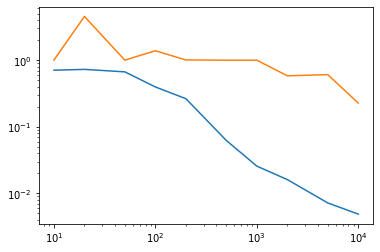

In [20]:
plt.loglog(n_samples,error_data_u)
plt.loglog(n_samples,error_data_f)